In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler

import time

kafka_topic_name = "songTopic"
kafka_bootstrap_servers = 'localhost:9092'



In [2]:
spark = SparkSession \
        .builder \
        .appName("Spotify Streaming Reccomendation System") \
        .master("local[*]") \
        .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

    

In [3]:
# Construct a streaming DataFrame that reads from test-topic
songs_df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
        .option("subscribe", kafka_topic_name) \
        .option("startingOffsets", "latest") \
        .load()

print("Printing Schema of songs_df: ")

songs_df.printSchema()

    

Printing Schema of songs_df: 
root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [4]:
songs_df1 = songs_df.selectExpr("CAST(value AS STRING)", "timestamp")


songs_schema_string = "order_id INT,id STRING, name STRING,popularity INT, duration_ms DOUBLE, explicit INT, " \
                           + "artists STRING, id_artists STRING, release_date STRING, " \
                           + "danceability DOUBLE," \
                           + "energy DOUBLE, key INT, loudness DOUBLE, " \
                           + "mode INT," \
                           + "speechiness DOUBLE," \
                           + "acousticness DOUBLE, instrumentalness DOUBLE, liveness DOUBLE, " \
                           + "valence DOUBLE, tempo DOUBLE, time_signature DOUBLE"



songs_df2 = songs_df1 \
        .select(from_csv(col("value"), songs_schema_string) \
                .alias("song"), "timestamp")


songs_df3 = songs_df2.select("song.*", "timestamp")
songs_df3.printSchema()



root
 |-- order_id: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [5]:
def simple():    
    songs_df3.createOrReplaceTempView("song_find");
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("update") \
            .option("truncate", "false") \
            .format("console") \
            .start()

    songs_agg_write_stream.awaitTermination()

    print("Songs Streaming...")
    
def csv_output():    
    song_find_text = spark.sql("SELECT name, artists FROM song_find")
    songs_agg_write_stream = song_find_text \
            .writeStream \
            .trigger(processingTime='5 seconds') \
            .outputMode("append") \
            .option("truncate", "false") \
            .option("path",'answ') \
            .option("checkpointLocation", "checkpoint_path") \
            .format("csv") \
            .start()

    songs_agg_write_stream.awaitTermination()

    print("Songs Streaming...")

In [6]:
songs_df3.createOrReplaceTempView("song_find");
song_find_text = spark.sql("SELECT * FROM song_find")
songs_agg_write_stream = song_find_text \
        .writeStream \
        .trigger(processingTime='5 seconds') \
        .outputMode("append") \
        .option("truncate", "false") \
        .format("memory") \
        .queryName("testedTable5") \
        .start()

songs_agg_write_stream.awaitTermination(1)

print("Songs Streaming...")

Songs Streaming...


In [11]:
df = spark.sql("SELECT * FROM testedTable5")

In [12]:
# getting the data from df.
df.show(3)

+--------+--------------------+--------------------+----------+-----------+--------+--------------+------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+--------------------+
|order_id|                  id|                name|popularity|duration_ms|explicit|       artists|        id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|           timestamp|
+--------+--------------------+--------------------+----------+-----------+--------+--------------+------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+--------------------+
|      70|2vOhKgXKFpej7mv3m...|Capítulo 1.21 - B...|         0|   102000.0|       0|FernandoPessoa|jtPCOoNZwqukwdDxrY|  1922-06-01|       0.625| 0.187| 10| -24.686|   1|      0.963|   

In [13]:
df.columns

['order_id',
 'id',
 'name',
 'popularity',
 'duration_ms',
 'explicit',
 'artists',
 'id_artists',
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'timestamp']

In [17]:
df_count = df.count()
df_count

44

In [18]:
df.describe('popularity').show()

+-------+----------+
|summary|popularity|
+-------+----------+
|  count|        44|
|   mean|       0.0|
| stddev|       0.0|
|    min|         0|
|    max|         0|
+-------+----------+



In [19]:
df.select('order_id','name','artists').show(10)

+--------+--------------------+--------------+
|order_id|                name|       artists|
+--------+--------------------+--------------+
|      70|Capítulo 1.21 - B...|FernandoPessoa|
|      71|Capítulo 2.4 - Ba...|FernandoPessoa|
|      72|Capítulo 2.14 - B...|FernandoPessoa|
|      73|The Girl That I M...|    DickHaymes|
|      74|Capítulo 1.7 - Ba...|FernandoPessoa|
|      75|Capítulo 1.9 - Ba...|FernandoPessoa|
|      76|Capítulo 2.9 - Ba...|FernandoPessoa|
|      77|Entrerriana - Rem...|IgnacioCorsini|
|      78|Pobre Cotorro - R...|IgnacioCorsini|
|      79|              Mirage|  AdolpheBrard|
+--------+--------------------+--------------+
only showing top 10 rows



In [20]:
# getting the number of unique artists
df.select('artists').distinct().count()

11

In [21]:
# finding if there is any duplicate rows and deleting it.
dup_count = df.dropDuplicates().count()
dup_count = df_count - dup_count
#dup_count

In [22]:
# get popular artists.
df.groupby('artists').agg({'popularity': 'mean'})
df.groupby('artists').count().orderBy('count', ascending=False).show()

+--------------------+-----+
|             artists|count|
+--------------------+-----+
|      FernandoPessoa|   18|
|      IgnacioCorsini|   11|
|          DickHaymes|    8|
|     MariaKonopnicka|    2|
|                 Uli|    2|
|            Georgius|    2|
|        AdolpheBrard|    1|
|DickHaymesVictorY...|    1|
|              Fortug|    1|
|DickHaymesHarryJa...|    1|
|           FlixMayol|    1|
+--------------------+-----+



In [23]:
df.columns

['order_id',
 'id',
 'name',
 'popularity',
 'duration_ms',
 'explicit',
 'artists',
 'id_artists',
 'release_date',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'timestamp']

In [24]:
df = df.sort(df.release_date.desc())

In [25]:
df = df.drop('order_id',
 'id',
 'explicit',
  'mode',
 'release_date',
 'id_artists',
 'time_signature',
 'timestamp')

In [26]:
df.columns

['name',
 'popularity',
 'duration_ms',
 'artists',
 'danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [27]:
import pandas as pd

98 tracks


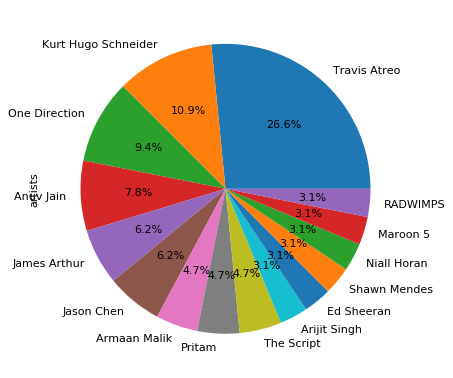

In [28]:
from spotify_api import getSong
song_data = getSong.passs()
add_df = song_data.head(1)


In [29]:
df.show(1)

+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+
|                name|popularity|duration_ms|       artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence| tempo|
+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+
|Capítulo 1.21 - B...|         0|   102000.0|FernandoPessoa|       0.625| 0.187| 10| -24.686|      0.963|       0.831|             0.0|   0.424|  0.576|76.537|
+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+
only showing top 1 row



In [30]:
df_sp = spark.createDataFrame(add_df)
df_sp.show()

+--------------------+---------+-----------+----------+------------+-----------+---+--------+----------------+------+-------+--------+------------+-------+
|                name|  artists|duration_ms|popularity|acousticness|speechiness|key|liveness|instrumentalness|energy|  tempo|loudness|danceability|valence|
+--------------------+---------+-----------+----------+------------+-----------+---+--------+----------------+------+-------+--------+------------+-------+
|MONTERO (Call Me ...|Lil Nas X|    137.875|       100|       0.297|      0.152|  8|   0.384|             0.0| 0.508|178.818|  -6.682|        0.61|  0.758|
+--------------------+---------+-----------+----------+------------+-----------+---+--------+----------------+------+-------+--------+------------+-------+



In [31]:
df = df.union(df_sp)
df.show(2)

+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+
|                name|popularity|duration_ms|       artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence| tempo|
+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+
|Capítulo 1.21 - B...|         0|   102000.0|FernandoPessoa|       0.625| 0.187| 10| -24.686|      0.963|       0.831|             0.0|   0.424|  0.576|76.537|
|Capítulo 2.4 - Ba...|         0|    97600.0|FernandoPessoa|       0.732| 0.176|  0| -21.808|      0.966|       0.623|             0.0|   0.442|  0.771|76.708|
+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+
only showing top 2 rows



In [32]:
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=[
 'duration_ms',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo'], outputCol='features')
assembled_data=assembler.setHandleInvalid("skip").transform(df)
assembled_data.show(2)

+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+--------------------+
|                name|popularity|duration_ms|       artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence| tempo|            features|
+--------------------+----------+-----------+--------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+------+--------------------+
|Capítulo 1.21 - B...|         0|   102000.0|FernandoPessoa|       0.625| 0.187| 10| -24.686|      0.963|       0.831|             0.0|   0.424|  0.576|76.537|[102000.0,0.625,0...|
|Capítulo 2.4 - Ba...|         0|    97600.0|FernandoPessoa|       0.732| 0.176|  0| -21.808|      0.966|       0.623|             0.0|   0.442|  0.771|76.708|[97600.0,0.732,0....|
+--------------------+----------+-----------+--------------+------------+------+---+--------+--

In [33]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
df=data_scale.transform(assembled_data)
df.show(2)

+--------------------+----------+-----------+--------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+
|                name|popularity|duration_ms|             artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|            features|        standardized|
+--------------------+----------+-----------+--------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+
|Nobody Knows You ...|        41|   177133.0|         BessieSmith|       0.614|0.0423|  4| -12.033|     0.0535|       0.996|         0.00293|   0.183|  0.211| 89.822|[177133.0,0.614,0...|[3.85152289574137...|
|        Weather Bird|        38|   161933.0|LouisArmstrongEar...|       0.831| 0.262|  8| -12.386|     0.0942|       0.984|           0.912|   0.204|  0.901|104.60

In [34]:
assembled_data

DataFrame[name: string, popularity: string, duration_ms: double, artists: string, danceability: double, energy: double, key: string, loudness: double, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, features: vector]

In [35]:
def getShiloutte():
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import ClusteringEvaluator
    silhouette_score=[]
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                    metricName='silhouette', distanceMeasure='squaredEuclidean')
    for i in range(2,10):

        KMeans_algo=KMeans(featuresCol='standardized', k=i)

        KMeans_fit=KMeans_algo.fit(df)

        output=KMeans_fit.transform(df)

        score=evaluator.evaluate(output)

        silhouette_score.append(score)

        return silhouette_score

In [36]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')


KMeans_algo=KMeans(featuresCol='standardized', k=4)
    
KMeans_fit=KMeans_algo.fit(df)
    
output_df =KMeans_fit.transform(df)
    

In [37]:
output_df.show(2)

+--------------------+----------+-----------+-----------+------------+------+----+--------+-----------+------------+----------------+--------+-------+------+--------------------+--------------------+----------+
|                name|popularity|duration_ms|    artists|danceability|energy| key|loudness|speechiness|acousticness|instrumentalness|liveness|valence| tempo|            features|        standardized|prediction|
+--------------------+----------+-----------+-----------+------------+------+----+--------+-----------+------------+----------------+--------+-------+------+--------------------+--------------------+----------+
|     Empty Bed Blues|      null|       27.0|          0|      1923.0| 0.709|null|     5.0|        1.0|       0.048|           0.995| 0.00341|   0.12| 0.553|[27.0,1923.0,0.70...|[5.87079303037926...|         0|
|Nobody Knows You ...|        41|   177133.0|BessieSmith|       0.614|0.0423|   4| -12.033|     0.0535|       0.996|         0.00293|   0.183|  0.211|89.822

In [38]:
output_df.select('prediction').distinct().count()

4

In [39]:
output_df.select('prediction').show(20)

+----------+
|prediction|
+----------+
|         0|
|         1|
|         3|
|         1|
|         3|
|         1|
|         3|
|         3|
|         3|
|         1|
|         3|
|         1|
|         3|
|         3|
|         1|
|         3|
|         3|
|         1|
|         3|
|         1|
+----------+
only showing top 20 rows



In [40]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [41]:
class SpotifyRecommender():
    def __init__(self, rec_data):
        #our class should understand which data to work with
        self.rec_data_ = rec_data
    
    #if we need to change data
    def change_data(self, rec_data):
        self.rec_data_ = rec_data
    
    #function which returns recommendations, we can also choose the amount of songs to be recommended
    def get_recommendations(self, song_name, amount=1):
        distances = []
        #choosing the data for our song
        song = self.rec_data_[(self.rec_data_.name.str.lower() == song_name.lower())].head(1).values[0]
        #dropping the data with our song
        res_data = self.rec_data_[self.rec_data_.name.str.lower() != song_name.lower()]
        for r_song in tqdm(res_data.values):
            dist = 0
            for col in np.arange(len(res_data.columns)):
                #indeces of non-numerical columns
                if not col in [0,1,5]:
                    #calculating the manhettan distances for each numerical feature
                    dist = dist + np.absolute(float(song[col]) - float(r_song[col]))
            distances.append(dist)
        res_data['distance'] = distances
        #sorting our data to be ascending by 'distance' feature
        res_data = res_data.sort_values('distance')
        columns = ['name', 'artists', 'acousticness', 'liveness', 'instrumentalness', 'energy', 'danceability', 'valence','duration_ms']
        return res_data[columns][:amount]

In [42]:
datad = output_df.select('name',
 'artists',
 'duration_ms',
 'danceability',
 'energy',
 'key',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'prediction')




datf = datad.toPandas()
datf.drop(datf[datf['artists'] == '0'].index, inplace = True)
datf.drop_duplicates(inplace=True)
datf.drop(datf[datf['danceability'] == 0.0000].index, inplace = True)
datf.drop(datf[datf['liveness'] == 0.000].index, inplace = True)
datf.drop(datf[datf['instrumentalness'] == 0.000000].index, inplace = True)
datf.drop(datf[datf['energy'] == 0.0000].index, inplace = True)
datf.drop(datf[datf['danceability'] == 0.000].index, inplace = True)
datf.drop(datf[datf['valence'] == 0.000].index, inplace = True)



In [46]:
recommender = SpotifyRecommender(datf)
x = add_df['name'].tolist()[0]

rec_song = recommender.get_recommendations(x, 8)


100%|███████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 14402.42it/s]


In [47]:
rec_song

,name,artists,acousticness,liveness,instrumentalness,energy,danceability,valence,duration_ms
89,L'enfer,Uli,0.199,0.0931,0.85600,0.325,0.657,0.105,40000.0
90,Graphite,Uli,0.144,0.0847,0.80200,0.684,0.644,0.138,104400.0
111,Le Petit Amant,JeanneSaintBonnet,0.996,0.1550,0.00597,0.283,0.656,0.670,120760.0
74,Nostalgia - Remasterizado,IgnacioCorsini,0.995,0.2060,0.63800,0.158,0.496,0.347,139760.0
106,As If I Didn't Have Enough On My Mind,DickHaymes,0.991,0.4190,0.85000,0.246,0.320,0.312,148440.0
72,Ensueño de Oro - Remasterizado,IgnacioCorsini,0.995,0.2020,0.95200,0.155,0.430,0.564,151027.0
26,Everybody Loves My Baby,ClarenceWilliamsBlueFive,0.996,0.2480,0.19900,0.193,0.514,0.665,152507.0
78,Pobre Gaucho - Remasterizado,IgnacioCorsini,0.995,0.1020,0.92900,0.131,0.476,0.635,155253.0


'name', 'artists', 'acousticness', 'liveness', 'instrumentalness', 'energy', 'danceability', 'valence'

In [48]:
rec_song.to_csv('rec_song.csv')